In [1]:
import pandas as pd
import os
import pandas as pd
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import LocallyLinearEmbedding
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

In [2]:
train_df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'train_selected_features.csv'))
test_df = pd.read_csv(os.path.join(os.getcwd(), 'data', 'test_selected_features.csv'))

x_train = train_df.drop(['log_shares'], axis=1)
y_train = train_df['log_shares']
x_test = test_df.drop(['log_shares'], axis=1)
y_test = test_df['log_shares']

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


In [7]:
optimization_results = pd.read_csv(os.path.join(os.getcwd(), 'results', 'results.csv'))
optimization_results.head(10)

,model,objective,best_params,best_value
0,ridge,mse,{'alpha': 0.6561251551486195},0.767945
1,ada,mse,"{'n_estimators': 85, 'learning_rate': 0.023324...",0.782347
2,ridge,mse,{'alpha': 0.666738772243351},0.768050
3,lgbm,mse,"{'n_estimators': 186, 'max_depth': 14, 'learni...",0.713646
4,dt,mse,"{'max_depth': 5, 'min_samples_split': 7, 'min_...",0.775022
5,rf,mse,"{'n_estimators': 199, 'min_samples_split': 9, ...",0.723682


In [6]:
optimization_results.iloc[3]['best_params']

"{'n_estimators': 186, 'max_depth': 14, 'learning_rate': 0.037507980506492504, 'num_leaves': 223, 'lambda_l1': 0.30553089435261865, 'lambda_l2': 0.7674806328883184, 'min_child_samples': 44}"

In [8]:
optimization_results.iloc[5]['best_params']

"{'n_estimators': 199, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 87}"

In [9]:
optimization_results.iloc[2]['best_params']

"{'alpha': 0.666738772243351}"

In [10]:
optimization_results.iloc[4]['best_params']

"{'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 9}"

In [11]:
optimization_results.iloc[1]['best_params']

"{'n_estimators': 85, 'learning_rate': 0.02332498770244577, 'loss': 'exponential'}"

In [12]:
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

# best tuned models
def create_lgb_model():
    return lgb.LGBMRegressor(**{'n_estimators': 186, 'max_depth': 14, 'learning_rate': 0.037507980506492504, 'num_leaves': 223,
                                 'lambda_l1': 0.30553089435261865, 'lambda_l2': 0.7674806328883184, 'min_child_samples': 44}, verbose=-1)

def create_ridge_model():
    return Ridge(**{'alpha': 0.666738772243351})

def create_rf_model():
    return RandomForestRegressor(**{'n_estimators': 199, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'max_depth': 87})

def create_dt_model():
    return DecisionTreeRegressor(**{'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 9})

def create_ada_model():
    return AdaBoostRegressor(**{'n_estimators': 85, 'learning_rate': 0.02332498770244577, 'loss': 'exponential'})

In [19]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import pearsonr

def evaluate_model(y_pred, y_test):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    pearson_corr, _ = pearsonr(y_test, y_pred)
    return mse, mae, r2, pearson_corr

def measure_model(model, x_train, y_train, x_test, y_test):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    metrics = evaluate_model(y_pred, y_test)
    return metrics

In [20]:
# baseline model
from sklearn.dummy import DummyRegressor
dummy_model = DummyRegressor(strategy='mean')

# get models
lgb_model = create_lgb_model()

ridge_model = create_ridge_model()

rf_model = create_rf_model()

dt_model = create_dt_model()

ada_model = create_ada_model()

In [21]:
# measure models performance on test set
metrics_baseline = measure_model(dummy_model, x_train, y_train, x_test, y_test)
metrics_lgb = measure_model(lgb_model, x_train, y_train, x_test, y_test)
metrics_ridge = measure_model(ridge_model, x_train, y_train, x_test, y_test)
metrics_rf = measure_model(rf_model, x_train, y_train, x_test, y_test)
metrics_dt = measure_model(dt_model, x_train, y_train, x_test, y_test)
metrics_ada = measure_model(ada_model, x_train, y_train, x_test, y_test)



/tmp/ipykernel_20401/3235167011.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson_corr, _ = pearsonr(y_test, y_pred)


In [22]:
# create a dataframe with the metrics
metrics_df = pd.DataFrame({
    'model': ['baseline', 'lgb', 'ridge', 'rf', 'dt', 'ada'],
    'mse': [metrics_baseline[0], metrics_lgb[0], metrics_ridge[0], metrics_rf[0], metrics_dt[0], metrics_ada[0]],
    'mae': [metrics_baseline[1], metrics_lgb[1], metrics_ridge[1], metrics_rf[1], metrics_dt[1], metrics_ada[1]],
    'r2': [metrics_baseline[2], metrics_lgb[2], metrics_ridge[2], metrics_rf[2], metrics_dt[2], metrics_ada[2]],
    'pearson_corr': [metrics_baseline[3], metrics_lgb[3], metrics_ridge[3], metrics_rf[3], metrics_dt[3], metrics_ada[3]]
})

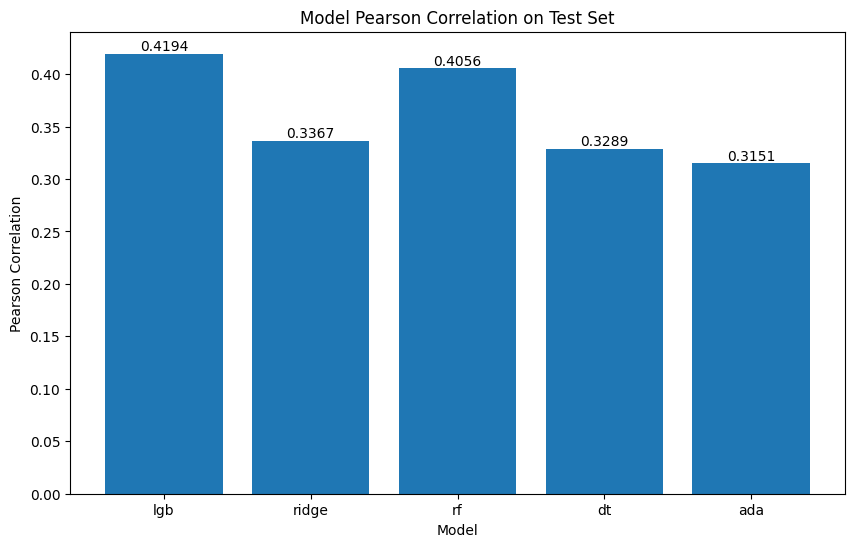

In [42]:
import matplotlib.pyplot as plt

# plot the metrics
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_df['model'], metrics_df['pearson_corr'])
plt.xlabel('Model')
plt.ylabel('Pearson Correlation')
plt.title('Model Pearson Correlation on Test Set')

# Annotate each bar with its exact value
for bar, value in zip(bars, metrics_df['pearson_corr']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.4f}",
        ha='center',
        va='bottom'
    )


plt.show()


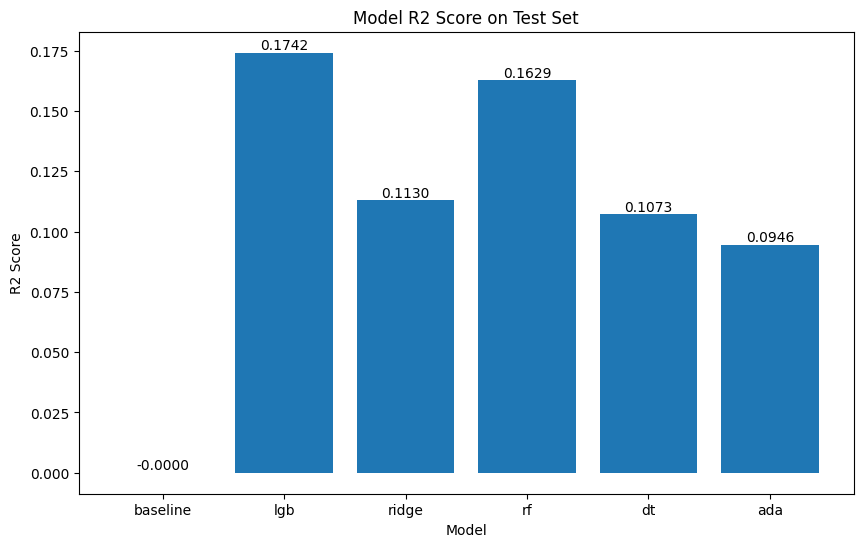

In [39]:
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_df['model'], metrics_df['r2'])
plt.xlabel('Model')
plt.ylabel('R2 Score')
plt.title('Model R2 Score on Test Set')

# Annotate each bar with its exact value
for bar, value in zip(bars, metrics_df['r2']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.4f}",
        ha='center',
        va='bottom'
    )


plt.show()


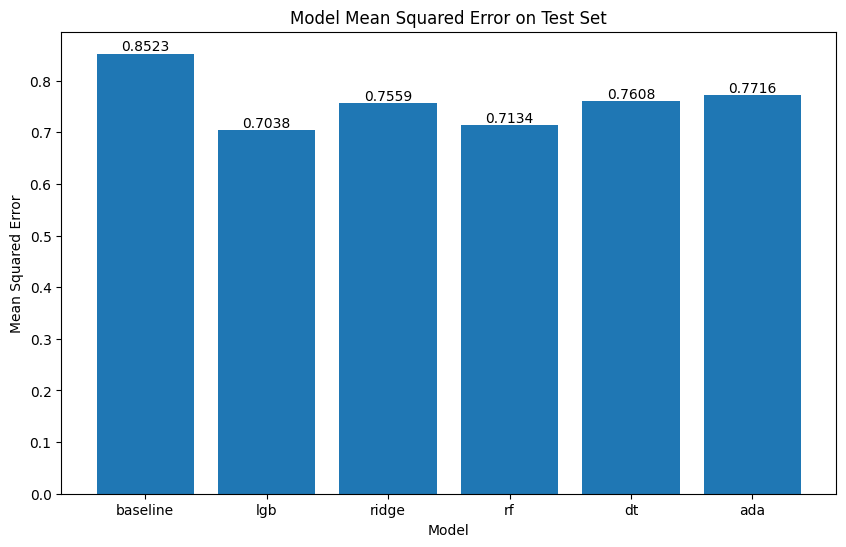

In [40]:
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_df['model'], metrics_df['mse'])
plt.xlabel('Model')
plt.ylabel('Mean Squared Error')
plt.title('Model Mean Squared Error on Test Set')

# Annotate each bar with its exact value
for bar, value in zip(bars, metrics_df['mse']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.4f}",
        ha='center',
        va='bottom'
    )


plt.show()


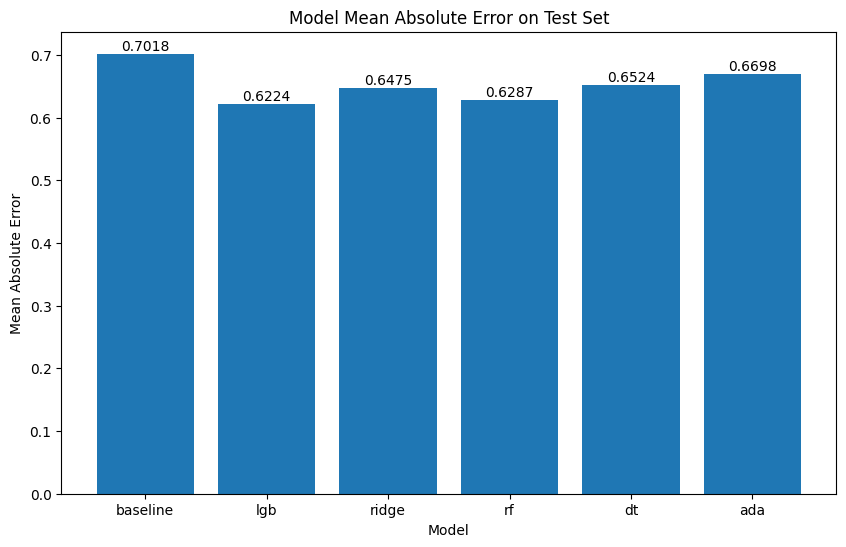

In [41]:
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_df['model'], metrics_df['mae'])
plt.xlabel('Model')
plt.ylabel('Mean Absolute Error')
plt.title('Model Mean Absolute Error on Test Set')

# Annotate each bar with its exact value
for bar, value in zip(bars, metrics_df['mae']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{value:.4f}",
        ha='center',
        va='bottom'
    )

plt.show()


## Dimensionality reduction

### PCA

In [41]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Also create an overlapping histogram for direct comparison



In [64]:
from sklearn.decomposition import PCA
import numpy as np


# train model with PCA with different number of components
explained_variances = np.arange(0.5, 1.0, 0.1)
explained_variances = np.append(explained_variances, 0.95)
explained_variances = np.append(explained_variances, 0.99)
explained_variances = np.append(explained_variances, 0.2)
stats = []
for ev in explained_variances:
    test_stat = {}
    test_stat['explained_variance'] = ev.item()
    pca = PCA(n_components=ev)
    x_train_pca = pca.fit_transform(x_train)
    x_test_pca = pca.transform(x_test)
    test_stat['num_components'] = x_train_pca.shape[1]
    lgb_model = create_lgb_model()
    lgb_model.fit(x_train_pca, y_train)
    y_pred_pca = lgb_model.predict(x_test_pca)
    metrics_pca = evaluate_model(y_pred_pca, y_test)
    test_stat['metrics'] = metrics_pca
    test_stat['y_pred'] = y_pred_pca
    stats.append(test_stat)

# train model with normal features
lgbm_model = create_lgb_model()
lgbm_model.fit(x_train, y_train)
y_pred_lgbm = lgbm_model.predict(x_test)
metrics_lgbm = evaluate_model(y_pred_lgbm, y_test)
stats.append({'explained_variance': None, 'num_components': x_train.shape[1], 'metrics': metrics_lgbm, 'y_pred': y_pred_lgbm})

/home/mircea/miniconda3/envs/bd_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/mircea/miniconda3/envs/bd_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/mircea/miniconda3/envs/bd_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/mircea/miniconda3/envs/bd_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/mircea/miniconda3/envs/bd_env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature na

In [65]:
len(stats)

9

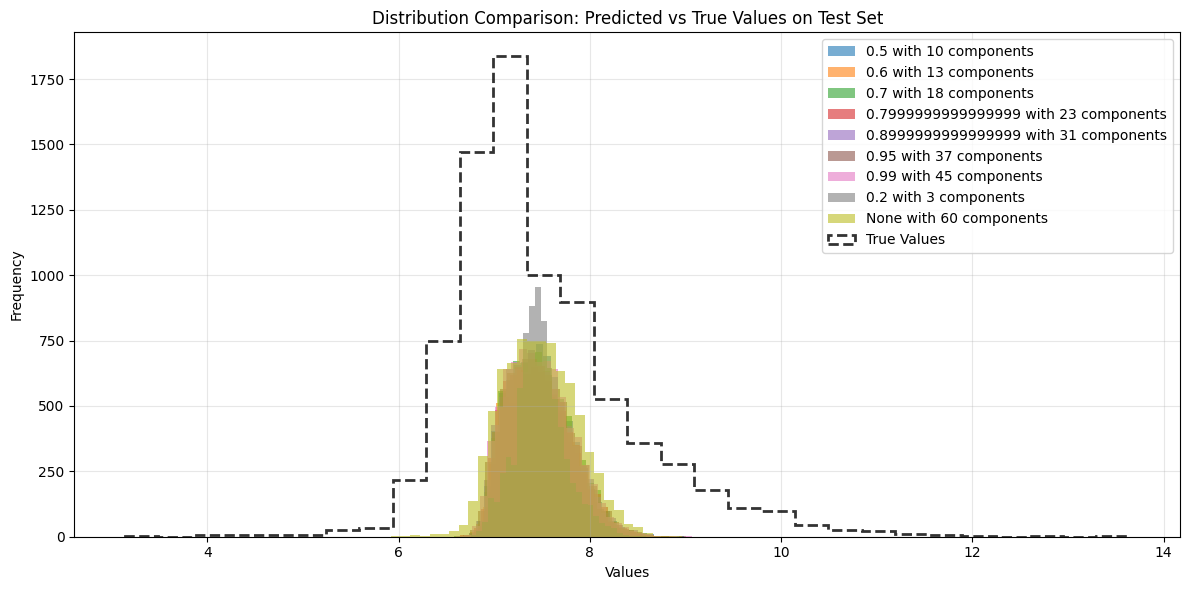

In [66]:
plt.figure(figsize=(12, 6))
for stat in stats:
    plt.hist(stat['y_pred'], bins=30, alpha=0.6, label=f'{stat['explained_variance']} with {stat['num_components']} components')
plt.hist(y_test, bins=30, alpha=0.8, label='True Values', color='black', linestyle='--', histtype='step', linewidth=2)

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution Comparison: Predicted vs True Values on Test Set')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

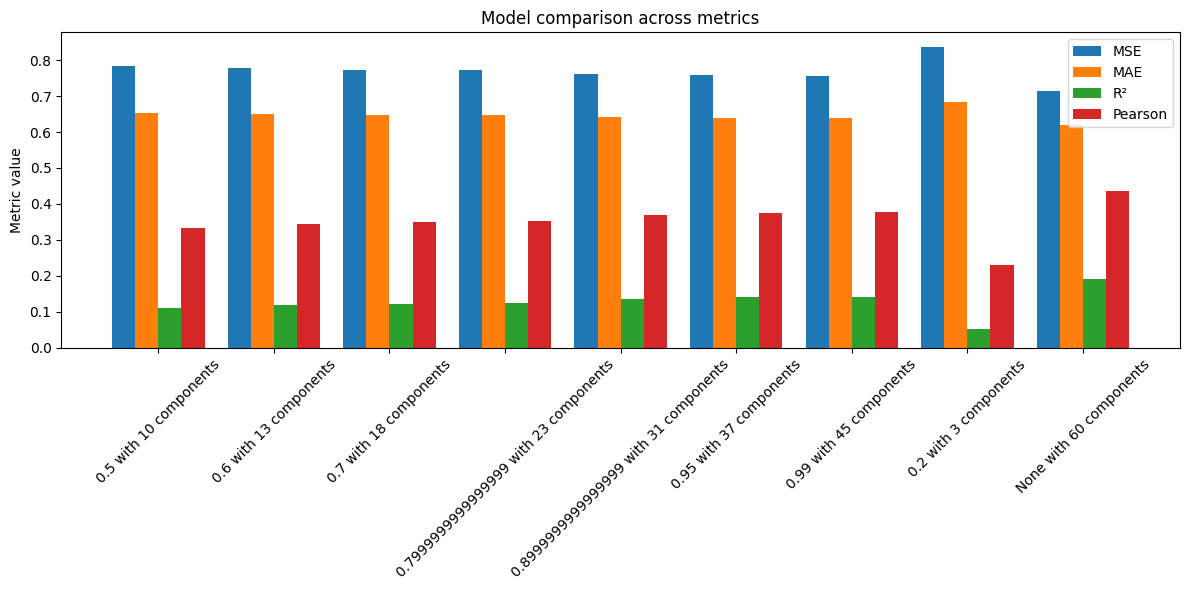

In [74]:
result = [s['metrics'] for s in stats]
results = np.array(result)  # shape: (10 models, 4 metrics)
model_names = [str(s['explained_variance']) + ' with ' + str(s['num_components']) + ' components' for s in stats]
metric_names = [ 'MSE', 'MAE',  'R²', 'Pearson']

# Transpose so metrics are on rows for plotting
results_T = results.T

x = np.arange(len(model_names))
width = 0.2

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.bar(x + i*width, results_T[i], width=width, label=metric_names[i])

plt.xticks(x + 1.5 * width, model_names, rotation=45)
plt.ylabel('Metric value')
plt.title('Model comparison across metrics')
plt.legend()
plt.tight_layout()
plt.show()

In [75]:
from umap import UMAP
import numpy as np

# Create a UMAP model
umap_model = UMAP(n_components=10, random_state=6)

x_train_umap = umap_model.fit_transform(x_train)
x_test_umap = umap_model.transform(x_test)

lgb_model = create_lgb_model()
lgb_model.fit(x_train_umap, y_train)
y_pred_umap = lgb_model.predict(x_test_umap)
metrics_umap = evaluate_model(y_pred_umap, y_test)

/home/mircea/miniconda3/envs/bd_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mircea/miniconda3/envs/bd_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/mircea/miniconda3/envs/bd_env/lib/python3.12/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/mircea/miniconda3/envs/bd_env/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mircea/miniconda3/envs/bd_env/lib/python3.12/si

In [76]:
metrics_umap

(0.8124756053308844,
 0.6634475322354508,
 0.0776747635017695,
 np.float64(0.28079850767637166))

In [77]:
stats[0]['metrics']

(0.7834515325675201,
 0.6535210240910746,
 0.11062299554709942,
 np.float64(0.3330189643469669))